In [8]:
# Import the required packages:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import datetime as dt
import copy
import time
import statsmodels.api as sm

In [9]:
# Change local directory:
import os
os.chdir("/Users/Michael Sun/Jupyterfiles")

In [10]:
# Process the stocks data from CRSP:
stocks = pd.read_csv("stocks.csv")

# Process the stocks data from CRSP:
unknowns = ["-66.0", "-77.0", "-88.0", "-99.0", "-99.99", "-999", "A", "B",
            "C", "D", "E", "S", "T", "P"]

# Create function to convert CRISP unkowns to np.nan
convert_unknows = lambda x: np.nan if x in unknowns else x

# Convert date column to date-time object
stocks['date'] = pd.to_datetime(stocks['date'], format = '%Y%m%d')

# Shift dates to the end of the month
stocks['date'] = stocks['date'] + MonthEnd(0)

# Create a year column
stocks['year'] = stocks['date'].dt.year

# Remove missing returns
stocks['RET'] = stocks['RET'].apply(convert_unknows).astype(float).fillna(0)
stocks['DLRET'] = stocks['DLRET'].apply(convert_unknows)\
                  .astype(float).fillna(0)

# Combine delisting and regular returns
stocks['RET'] = (1 + stocks['RET']) * (1 + stocks['DLRET']) - 1

# Make sure price is positive
stocks['PRC'] = stocks['PRC'].abs()

# Remove 0-valued prices
stocks = stocks.loc[stocks['PRC'] > 0]

# Remove negative shares outstanding
stocks = stocks.loc[stocks['SHROUT'] > 0]

# Only consider stocks traded on the NYSE, NASDEQ, or AMEX
stocks = stocks.loc[stocks['SHRCD'].isin([10, 11]) & stocks['EXCHCD']\
         .isin([1, 2, 3])]

# Drop columns that have done their jobs
stocks.drop(['DLRET', 'SHRCD', 'EXCHCD', 'PERMCO'], axis = 1, inplace = True)

In [11]:
# Use the link table to connect stocks with their SIC codes:
# Import the link table:
link = pd.read_csv("link.csv")

# Clean the link table data:
link['LINKDT'] = link['LINKDT'].apply(convert_unknows)

# Correct the data format in the link table:
link['LINKDT'] = pd.to_datetime(link['LINKDT'], format = "%Y-%m-%d")

link['LINKENDDT'] = link['LINKENDDT'].apply(convert_unknows)
link['LINKENDDT'] = pd.to_datetime(link['LINKENDDT'], format = "%Y-%m-%d")

# Fill missing with date out of range:
link['LINKENDDT'] = link['LINKENDDT'].fillna(pd.to_datetime('20200901', 
                                                            format = "%Y%m%d"))

# Only keep LINKPRIM of P and C:
link = link.loc[link['LINKPRIM'].isin(["P", "C"])]

# Only consider LIID of 01:
link = link.loc[link["LIID"] == '01']

# Import the SIC codes data from Compustats:
df = pd.read_csv("sic_codes.csv")

# Merge df with link table:
df = df.merge(link, on = "gvkey")

# Extract the year from the datadate column:
df['datadate'] = pd.to_datetime(df['datadate'], format = "%m/%d/%Y")
df['year'] = df['datadate'].dt.year

# Verify that date within valid range:
df = df.loc[(df['LINKDT'] < df['datadate']) & 
            (df['datadate'] < df['LINKENDDT'])]

# Drop unneeded variables:
df = df.drop(['conm', 'LINKPRIM', 'LIID', 'fyear', 'datadate',
              "LINKDT", "LINKENDDT"], axis = 1)

# Merge df and CRSP (stocks) data:
df = stocks.merge(df, left_on = ['PERMNO', 'year'], 
                      right_on = ['LPERMNO', 'year'], how = "left")

# Reset the index of the dataframe:
df.reset_index(drop = True, inplace = True)

# Drop duplicates
df.drop_duplicates(inplace = True)

# Only consider LC link when duplicates
df['count'] = df[['date', 'PERMNO', 'LPERMCO']].groupby(['date', 'LPERMCO'])\
    .transform('count')

# If duplicates, only consider the LC link
df = df.loc[(df['count'] < 2) | (df['LINKTYPE'] == 'LC')]

# Forward fill SIC
df['sic'] = df.groupby('PERMNO')['sic'].transform(lambda x: x.ffill())


# Drop unneeded variables:
df = df.drop(["LINKTYPE", "LPERMNO", "LPERMCO", "count"], axis = 1)

In [12]:
# Prepare the data for running the Kalman-filter algorithm:
# Rename the dataframe so as to indicate that the data cleaning process
# is over:
stocks_kf = copy.deepcopy(df)

# Fill individual missing stock returns with 0's:
stocks_kf['RET'] = stocks_kf['RET'].fillna(0)

# Trim the industry code by 2 digit, reducing the number of industry 
# categories by about half to 73.
stocks_kf['sic'] = (0.01 * stocks_kf['sic']).astype('int')

# Create the industry average returns dataframe:
ind_avg_ret = pd.DataFrame(stocks_kf.groupby(['date', 'sic'])['RET'].mean())\
              .reset_index()

ind_mom = ind_avg_ret.pivot_table(values='RET', index='date', columns='sic')\
          .reset_index() 

# Train-test split:
ind_kf_test = ind_mom[ind_mom['date'].dt.year >= 2001]

In [13]:
# Implement the Kalman Filter algorithm:

# Define window for Kalman filter
kal_win = len(ind_kf_test.columns) - 1

# Create data frame to record signal values
kal_mom = pd.DataFrame(index = ind_kf_test.index[kal_win:], 
                       columns = ind_kf_test.columns)

# We will loop over the date
dates = np.unique(ind_kf_test['date'])[kal_win:]

for date in dates:
    
    # Obtain the end of the signal formation, exclusive
    stop = np.sum(ind_kf_test['date'] < date)
    
    # Record the beginning of signal, inclusive
    start = stop - kal_win
    
    # Get 'measurement' values for Kalman filter
    X = np.array(ind_kf_test.iloc[start:stop, 1:])
    
    # Check for NaN values in the industry columns:
    bad_col = np.mean(X != X, axis=0) > 0.25
    X = X[:, ~bad_col]
    X = np.nan_to_num(X)
    

    # Record the number of variables
    n = X.shape[1]

    # Save identity matrix
    I = np.eye(n)

    # Initialize Kalman filter:
    kf = KalmanFilter(initial_state_mean = np.zeros(n),
                      initial_state_covariance =  0.10**2 * I,
                      transition_matrices = I,
                      observation_matrices = I,
                      observation_covariance = 0.10**2 * I,
                      transition_covariance = I)    

    try:
        
        kf = kf.em(X, n_iter = 5)
        mu, sigma = kf.smooth(X)
    
    except:
        
        # If det(X'X) is too small for Kalman filter, use 0 as state estimates
        mu, sigma = [np.zeros(n)], [np.zeros((n, n))]
    
    # Record date for later merger
    kal_mom.loc[stop, 'date'] = date    
    
    # Record signal
    col_sel = np.concatenate([[False], ~bad_col])
    kal_mom.loc[stop, col_sel] = mu[-1] - 0.5 * np.diag(sigma[-1])

In [14]:
# Change structure of data frame so industries are observations:
kal_mom = pd.melt(kal_mom, id_vars = ['date'], 
                  value_vars = kal_mom.columns[1:])

# Change column names
kal_mom.columns = ['date', 'sic', 'Kal_mom']


In [15]:
# Change structure of data frame so industries are observations
ind_kf_test = pd.melt(ind_kf_test, id_vars = ['date'], 
                       value_vars = ind_kf_test.columns[1:])

# Change column names:
ind_kf_test.columns = ['date', 'sic', 'RET']

In [16]:
# Merge the Kalman-filter algothrithm results with the training industry Kalman-filter data frame:
kf_res = ind_kf_test.merge(kal_mom, on = ['date', 'sic'])


kf_res['tercile'] = kf_res[['date', 'Kal_mom']].groupby('date')['Kal_mom']\
                    .transform(lambda x: pd.qcut(x, 3, labels = False))

# Add 1 to quintile to avoid confusion
kf_res['tercile'] = 1 + kf_res['tercile']

# Drop columns that have done their jobs
kf_res.drop(['Kal_mom'], axis = 1, inplace = True)

In [17]:
# Second sort based on Fundamental Return Spread:
# 1. Load the Hoberg data:
hoberg_file = 'hoberg_data.txt'

hoberg = pd.read_csv(hoberg_file, delimiter='\t')

# 2. Set similarity score to be greater than 0.07:
hoberg = hoberg.loc[hoberg['score'] > 0.07, :]

# 3. Remove the score column:
hoberg.drop('score', axis=1, inplace=True)

# 4. Merge the hoberg data with the df dataframe:
df2 = copy.deepcopy(df)

df2.drop(['sic', 'PRC', 'SHROUT'], axis=1, inplace=True)

df2.rename(columns = {'RET': 'RET2', 'gvkey': 'gvkey2', 'PERMNO': 'PERMNO2'},
           inplace=True)

# Add 1 to the year in the hoberg data:
hoberg['year'] = hoberg['year'] + 1

df_hoberg = df.merge(hoberg, left_on=['year', 'gvkey'], 
                     right_on=['year', 'gvkey1'])

del(hoberg)

df_hoberg.drop('year', axis=1, inplace=True)

df_hoberg = df_hoberg.merge(df2, on = ['gvkey2', 'date'])

df_hoberg = df_hoberg.loc[df_hoberg['PERMNO'] != df_hoberg['PERMNO2'], :]

# 5. Compute the number of firms in each fundamental group:
df_hoberg['N'] = df_hoberg.groupby(['date', 'PERMNO'])['PERMNO2']\
                 .transform('count')

# 6. Compute the fundamental group returns:                 
df_hoberg['fun_ret'] = df_hoberg.groupby(['date', 'PERMNO'])['RET2']\
                       .transform('mean')
                       
# 7. Clean up the merged hoberg data:
df_hoberg = df_hoberg.drop(['gvkey', 'gvkey2', 'PERMNO2', 'RET2'], axis=1)

df_hoberg.drop_duplicates(inplace=True)

df_hoberg.reset_index(drop=True, inplace=True)

# 8. Trim the industry code by 2 digit:
df_hoberg['sic'] = (0.01 * df_hoberg['sic']).astype('int')

# 9. Compute the spread, then shift the observation by 1 period:
df_hoberg['spread'] = df_hoberg['fun_ret'] - df_hoberg['RET']

df_hoberg.sort_values(['PERMNO', 'date'], inplace=True)

df_hoberg['lag_spread'] = df_hoberg.groupby('PERMNO')['spread']\
                          .shift(periods=1)

In [18]:
# Impose the liquidity constraints:

# 10. Compute the 3-month rolling averge of lagged market equity:
df_hoberg['lag_PRC'] = df_hoberg.groupby('PERMNO')['PRC'].shift(periods=1)

df_hoberg['lag_SHROUT'] = df_hoberg.groupby('PERMNO')['SHROUT']\
                          .shift(periods=1)

df_hoberg['lag_ME'] = df_hoberg['lag_PRC'] * df_hoberg['lag_SHROUT']

df_hoberg['Avg_lag_ME_tm'] = df_hoberg.groupby('PERMNO')['lag_ME']\
                             .transform(lambda x: x.rolling(3).mean())

# 11. Compute the 3-month rolling averge of prices:
df_hoberg['Avg_PRC_tm'] = df_hoberg.groupby('PERMNO')['PRC']\
                          .transform(lambda x: x.rolling(3).mean())

# 12. Check the 1-month validity and 3-month validity of observations:
df_hoberg['om_valid'] = df_hoberg['date'].shift() + dt.timedelta(days = 7)\
                     + MonthEnd(0) == df_hoberg['date'] + MonthEnd(0)

df_hoberg.loc[df_hoberg['om_valid'] == False, 'lag_spread'] = np.nan    
    
df_hoberg['tm_valid'] = df_hoberg['date'].shift(3) + dt.timedelta(days = 7)\
                     + MonthEnd(3) == df_hoberg['date'] + MonthEnd(0)

df_hoberg.loc[df_hoberg['tm_valid'] == False, 
              ['Avg_lag_ME_tm', 'Avg_PRC_tm']] = np.nan

# 13. Remove NaN observations in lag spread, average lag ME, and average
# price:
df_hoberg = df_hoberg[(df_hoberg['lag_spread'].notna()) & 
                      (df_hoberg['Avg_lag_ME_tm'].notna()) & 
                      (df_hoberg['Avg_PRC_tm'].notna())]

df_hoberg.drop(['om_valid', 'tm_valid'], axis=1, inplace=True)

# 14. Check if the 3-month rolling averge of prices is greater than $10:
price_level = 10
    
df_hoberg['PRC_valid'] = df_hoberg['Avg_PRC_tm'] >= price_level  

# 15. Check if the 3-month rolling averge of lagged ME is at the 90th
# percentile or higher.
df_hoberg['lag_ME_np'] = df_hoberg.groupby('date')['Avg_lag_ME_tm']\
                         .transform(lambda x: x.quantile(q=0.1))
                         
df_hoberg['ME_valid'] = df_hoberg['Avg_lag_ME_tm'] >= df_hoberg['lag_ME_np']                         

# 16. Filter the data based on N values, average price, and average ME:
df_hoberg = df_hoberg[(df_hoberg['N'] >= 5) & 
                      (df_hoberg['PRC_valid']) &
                      (df_hoberg['ME_valid'])]

df_hoberg.drop(['PRC', 'SHROUT', 'gvkey1', 'year', 'N', 'fun_ret', 'spread',
                'lag_PRC', 'lag_SHROUT', 'lag_ME', 'Avg_lag_ME_tm', 
                'Avg_PRC_tm', 'PRC_valid', 'lag_ME_np', 'ME_valid'],
               axis = 1, inplace = True)

df_hoberg = df_hoberg[df_hoberg['date'].dt.year >= 2008]

In [19]:
# Combine the results of the second sort and the results of the Kalman-filter algothrim:

# 17. Select the winning/losing sic codes from the Kalman Filter results:
kf_res_win = kf_res[kf_res['tercile'] == 3]

kf_res_los = kf_res[kf_res['tercile'] == 1]

# 18. Filter out the winners from the hoberg data:
hoberg_kf_win = pd.merge(kf_res_win, df_hoberg, on = ['date', 'sic'])

hoberg_kf_los = pd.merge(kf_res_los, df_hoberg, on = ['date', 'sic'])

hoberg_kf_win.drop(['RET_x', 'tercile'], axis = 1, inplace = True)

hoberg_kf_los.drop(['RET_x', 'tercile'], axis = 1, inplace = True)

# 19. Decile sort on the winning/losing end:
hoberg_kf_win['decile'] = hoberg_kf_win.groupby('date')['lag_spread']\
                            .transform(lambda x: pd.qcut(x, 5, labels = False))
                            
hoberg_kf_los['decile'] = hoberg_kf_los.groupby('date')['lag_spread']\
                            .transform(lambda x: pd.qcut(x, 5, labels = False))
                            
# Add 1 to quintile to avoid confusion
hoberg_kf_win['decile'] = 6 + hoberg_kf_win['decile']

hoberg_kf_los['decile'] = 1 + hoberg_kf_los['decile']

# 20. Perform the second sort:
hoberg_kf_win = hoberg_kf_win[hoberg_kf_win['decile'] == 10]

hoberg_kf_los = hoberg_kf_los[hoberg_kf_los['decile'] == 1]

# 21. Combine the winners and losers to a single dataframe:
hoberg_kf_df = pd.concat([hoberg_kf_win, hoberg_kf_los],
                         axis=0, ignore_index=True)

In [20]:
# 22. Compute the results:
hoberg_kf_res = hoberg_kf_df.groupby(['date', 'decile'])['RET_y'].mean()\
                .reset_index()

hoberg_kf_res = hoberg_kf_res.pivot(index = 'date', columns = 'decile',
                                    values = 'RET_y').reset_index()

# Calculate winners minus losers
hoberg_kf_res['WML'] = hoberg_kf_res[10] - hoberg_kf_res[1]

# Create data frame for return statistics
hoberg_stats = pd.DataFrame(index = hoberg_kf_res.columns[1:])

# Compute the annualized mean returns:
hoberg_stats['mean'] = 12 * hoberg_kf_res.mean()

# Compute the annualized standard deviation:
hoberg_stats['sd'] = np.sqrt(12) * hoberg_kf_res.std()

# Compute the annualized skew:
hoberg_stats['skew'] = 12**(3/2) * hoberg_kf_res.skew()

# Print the result statistics:
print(hoberg_stats)

            mean        sd       skew
decile                               
1.0     0.034129  0.225887 -28.229686
10.0    0.143228  0.202491   2.202514
WML     0.109099  0.183361   3.363063


<ipython-input-20-c407f8a742e7>:15: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  hoberg_stats['mean'] = 12 * hoberg_kf_res.mean()


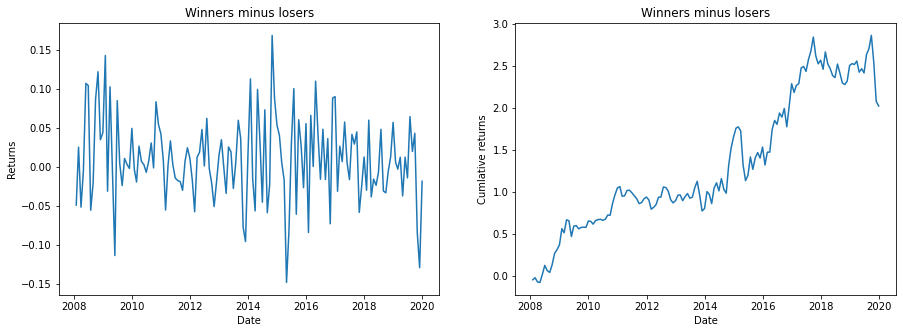

In [21]:
# Plot returns：
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

ax1.plot(hoberg_kf_res['date'], hoberg_kf_res['WML'])
ax1.set_xlabel('Date') 
ax1.set_ylabel('Returns') 
ax1.set_title('Winners minus losers') 

ax2.plot(hoberg_kf_res['date'], (1 + hoberg_kf_res['WML']).cumprod() - 1) 
ax2.set_xlabel('Date') 
ax2.set_ylabel('Cumlative returns') 
ax2.set_title('Winners minus losers') 

plt.show()

In [22]:
# Load Fama French factors
FF = pd.read_csv('FF.csv')

# Convert date column into date-time object
FF['date'] = pd.to_datetime(FF['date'], format = '%m/%d/%Y') + MonthEnd(0)

# Convert returns to a decimal
FF.iloc[:, 1:] = FF.iloc[:, 1:].div(100)

In [23]:
# Create function to get factor loadings
def get_factor_loadings(result, column, FF):
    
    # Merge data with Fama French factors
    data = result.merge(FF, on = 'date')
    
    # Create numpy array of Fama French factors
    X = sm.add_constant(data[['Mkt-RF', 'SMB', 'HML', 'MOM']].values)
    
    # Create numpy array for response variable
    y = data[column].values
    
    output = sm.OLS(y, X)
    
    output = output.fit()
    
    print(output.summary(xname = ['alpha', 'Mkt-RF', 'SMB', 'HML', 'MOM'], yname = str(column)))

In [24]:
get_factor_loadings(hoberg_kf_res, 10, FF)

                            OLS Regression Results                            
Dep. Variable:                     10   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     80.12
Date:                Sat, 27 Feb 2021   Prob (F-statistic):           4.05e-35
Time:                        17:01:43   Log-Likelihood:                 291.15
No. Observations:                 144   AIC:                            -572.3
Df Residuals:                     139   BIC:                            -557.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0046      0.003      1.648      0.1

In [25]:
get_factor_loadings(hoberg_kf_res, 1, FF)

                            OLS Regression Results                            
Dep. Variable:                      1   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     75.61
Date:                Sat, 27 Feb 2021   Prob (F-statistic):           6.42e-34
Time:                        17:01:43   Log-Likelihood:                 272.52
No. Observations:                 144   AIC:                            -535.0
Df Residuals:                     139   BIC:                            -520.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha         -0.0053      0.003     -1.670      0.0

In [26]:
get_factor_loadings(hoberg_kf_res, "WML", FF)

                            OLS Regression Results                            
Dep. Variable:                    WML   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.441
Date:                Sat, 27 Feb 2021   Prob (F-statistic):             0.0497
Time:                        17:01:43   Log-Likelihood:                 224.24
No. Observations:                 144   AIC:                            -438.5
Df Residuals:                     139   BIC:                            -423.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0099      0.004      2.230      0.0